# Compute the gauge transformation with approximating $t \sim \tau$

### Set parameters and environment  variables

In [7]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [8]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.exact_lcgauge as lc_gauge

### We define the simulatie a Glasma event and save the plus and eta components for every time step

In [27]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)
    
    # We create the objects where we will copy the simulated fields
    ux = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta = np.zeros((nplus, N*N, su. GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the temporal gauge U+ field
    uplus_temp = np.zeros((nplus, N, N, su.GROUP_ELEMENTS), su.GROUP_TYPE)
    
    # We create an object to store the gauge transformation operator at one xplus and the previous one
    vlc0 = su.GROUP_TYPE([[[su.unit() for z in range(N)] for y in range(N)] for xplus in range(N)])
    vlc1 = su.GROUP_TYPE([[[su.unit() for z in range(N)] for y in range(N)] for xplus in range(N)])
    
    # We create an object to store the LC gauge U+ field
    uplus_lc = np.zeros((nplus-1, N, N, su.GROUP_ELEMENTS), su.GROUP_TYPE)
    
    with tqdm(total=maxt) as pbar:
        for t_tot in range(maxt):
                        
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            # When only transform the fields when the transverse and tau lattice match
            if t_tot%DTS == 0:
                t = t_tot//DTS
                
                # We copy the Glasma fields at every time step
                ux[t] = s.d_u1[:,0,:].copy()
                aeta[t] = s.aeta1.copy()
                
                ux_r = ux.reshape(nplus, N, N, su.GROUP_ELEMENTS)
                aeta_r = aeta.reshape(nplus, N, N, su.GROUP_ELEMENTS)
                
                # We compute the plus component of the fields
                for y in range(N):
                    for z in range(t+1):
                        
                        # Over the Glasma light-cone we use Ux(tau=0)
                        if z == t:
                            uplus_temp[t, y, N//2+z] = ux_r[0, t, y]
                            uplus_temp[t, y, N//2-z] = ux_r[0, t, y]
                            
                        else:
                            uplus_temp[t, y, N//2+z] = su.mul(ux_r[round(np.sqrt(t**2-z**2)), t, y], su.mexp(su.mul_s(aeta_r[round(np.sqrt(t**2-z**2)), t, y], z*a/(t**2-z**2))))
                            uplus_temp[t, y, N//2-z] = su.mul(ux_r[round(np.sqrt(t**2-z**2)), t, y], su.mexp(su.mul_s(aeta_r[round(np.sqrt(t**2-z**2)), t, y], -z*a/(t**2-z**2))))
                        
                        # We construct at every time step the gauge transformation operator for every x^+ = cte slice
                        for xplus in range(nplus):
                            
                            if xplus > t:
                                uminus_p = su.unit(); uminus_m = su.unit()
                                if z == t:
                                    uminus_p = su.dagger(ux_r[0, 2*xplus-t, y])
                                    uminus_m = su.dagger(ux_r[0, 2*xplus-t, y])
                                
                                else:    
                                    uminus_p = su.mul(su.dagger(ux_r[round(np.sqrt(t**2-z**2)), 2*xplus-t, y]), su.mexp(su.mul_s(aeta_r[round(np.sqrt(t**2-z**2)), 2*xplus-t, y], z*a/(t**2-z**2))))
                                    uminus_m = su.mul(su.dagger(ux_r[round(np.sqrt(t**2-z**2)), 2*xplus-t, y]), su.mexp(su.mul_s(aeta_r[round(np.sqrt(t**2-z**2)), 2*xplus-t, y], -z*a/(t**2-z**2))))
                            
                                vlc1[xplus, y, N//2+z] = su.mul(uminus_p, vlc0[xplus, y, N//2+z])
                                vlc1[xplus, y, N//2-z] = su.mul(uminus_m, vlc0[xplus, y, N//2-z])
                            
                            # We gauge transform the links    
                            elif xplus == t and t != 0:
                                uplus_lc[t-1, y, N//2+z] = su.mul(su.dagger(vlc1[t, y, N//2+z]), su.mul(uplus_temp[t-1, y, N//2+z], vlc0[t, y, N//2+z]))
                                uplus_lc[t-1, y, N//2-z] = su.mul(su.dagger(vlc1[t, y, N//2-z]), su.mul(uplus_temp[t-1, y, N//2+z], vlc0[t, y, N//2-z]))
                
        
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields in a dictionary
    output["nplus"] = nplus
    output["uplus_temp"] = uplus_temp
    output["uplus_lc"] = uplus_lc
    
    return output

In [28]:
# We perform the simulation

import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    uplus_temp = output['uplus_temp']
    uplus_lc = output['uplus_lc']
                    
    # np.save(os.path.join('temp_fields', 'result_%i.npy' %n), uplus_temp)

Kernel xi: 0 d:  0 did not reach goal. check:  0.006644385620205844
Kernel xi: 0 d:  1 did not reach goal. check:  0.005147629440992151
Kernel xi: 1 d:  0 did not reach goal. check:  0.0056326827581311845
Kernel xi: 1 d:  1 did not reach goal. check:  0.004552470920656086
Kernel xi: 2 d:  0 did not reach goal. check:  0.0048283062889599715
Kernel xi: 2 d:  1 did not reach goal. check:  0.0021008361306738077
Kernel xi: 3 d:  0 did not reach goal. check:  0.004593087752629282
Kernel xi: 3 d:  1 did not reach goal. check:  0.00047506499487730806
Kernel xi: 4 d:  0 did not reach goal. check:  0.004317298679578808
Kernel xi: 4 d:  1 did not reach goal. check:  0.001620674330685989
Kernel xi: 5 d:  0 did not reach goal. check:  0.0032127629971245666
Kernel xi: 5 d:  1 did not reach goal. check:  0.0052295141250758
Kernel xi: 6 d:  0 did not reach goal. check:  0.0019063916934217307
Kernel xi: 6 d:  1 did not reach goal. check:  0.007959398571342391
Kernel xi: 7 d:  0 did not reach goal. chec

100%|██████████| 512/512 [01:30<00:00,  5.65it/s]


In [29]:
# We extract the color components

uplus_temp_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, uplus_temp)
uplus_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, uplus_lc)

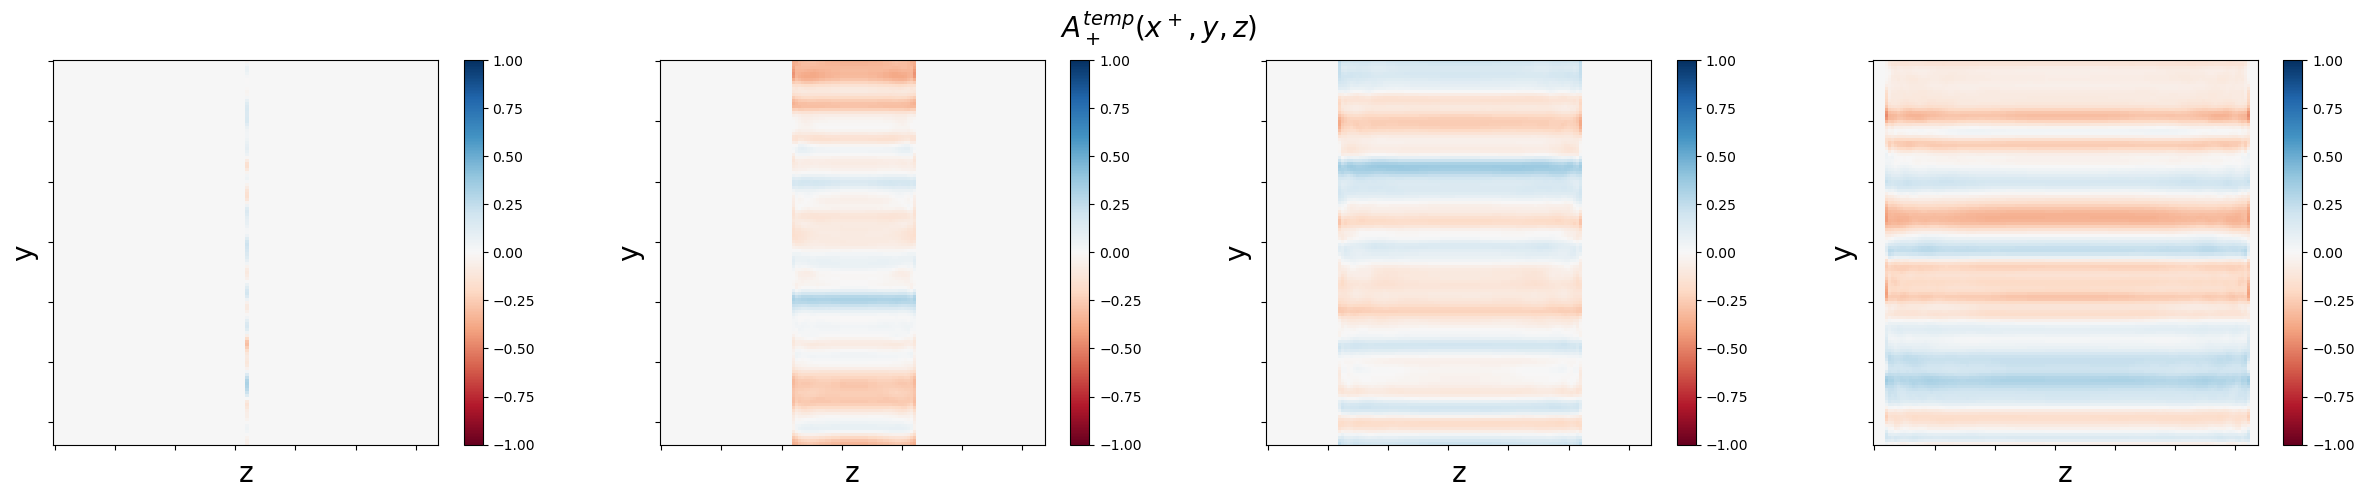

In [30]:
# We plot the results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(uplus_temp_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('temporal_gauge_fields')


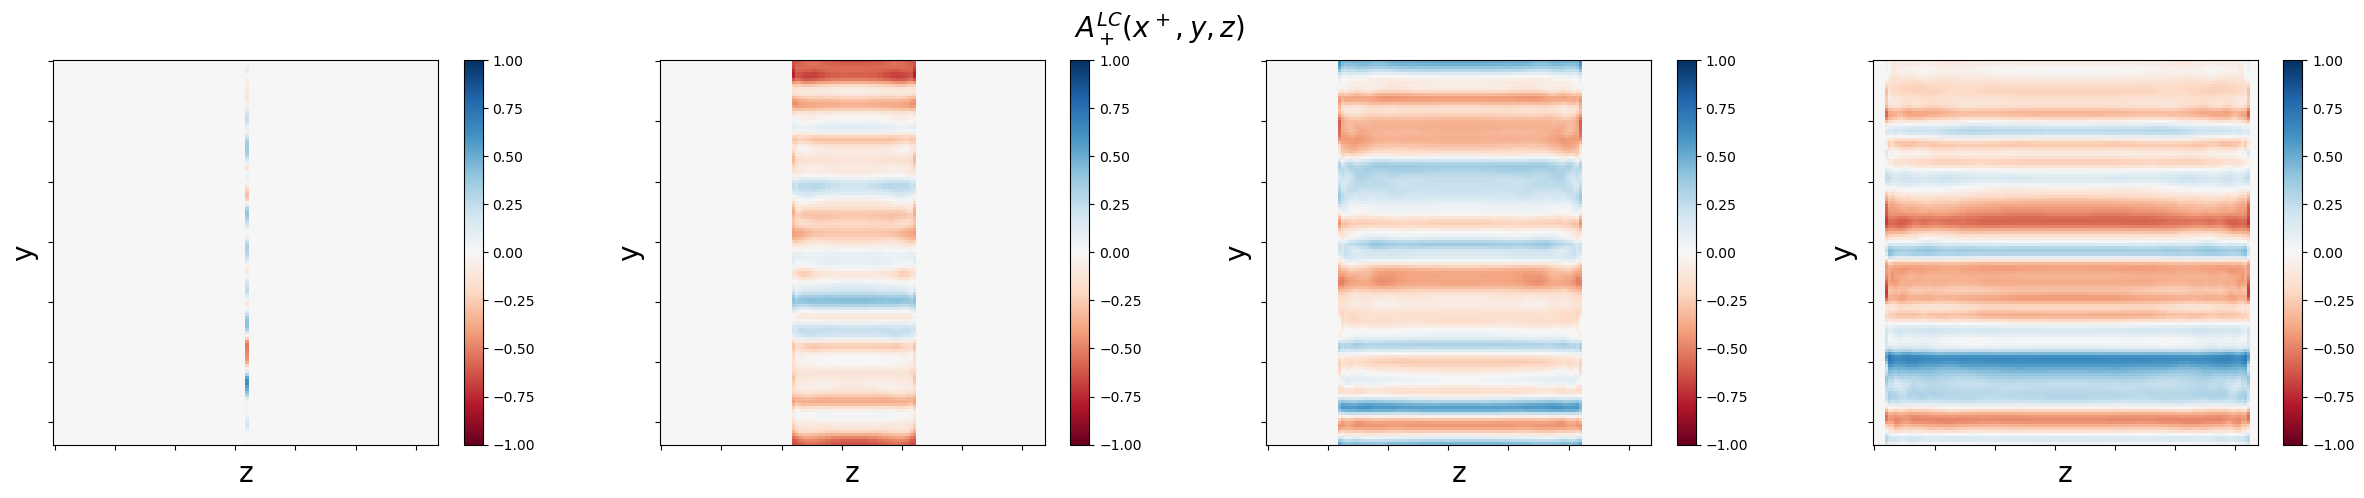

In [31]:
# We plot the results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{LC}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(uplus_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('lc_gauge_fields')